# Line Fitting Model

## Generating observations

For our test problem, we'll do a three-parameter model which fits a straight line to data. The parameters will be the slope, the intercept, and the scatter about the line; the scatter in this case will be treated as a nuisance parameter.

$\hat{y} = f(x | \alpha, \beta) = \alpha x_i + \beta$


with Gaussian noise on the observed values,

$ P(x_i, y_i | \alpha, \beta, \sigma) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp [\frac{-(y_i - \hat{y_i})^2}{2\sigma^2}] $

$ \forall i$, likelihood function becomes:

$ P(x, y | \alpha, \beta, \sigma) = (2\pi\sigma^2) ^ {-N/2} \exp [\frac{1}{2\sigma^2} \sum_{i=1}^{N} -(y_i - \hat{y_i})^2] $

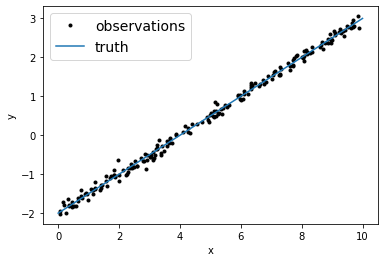

In [16]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

# slope, intercept, variance
true_params = np.array([0.5, -2, 0.1])

N = 200
t = np.linspace(0, 10, 2)
x = np.random.uniform(0, 10, N) # we are limiting the data generation from 0 to 10
y = x * true_params[0] + true_params[1]
y_obs = y + true_params[-1] * np.random.randn(N)

plt.plot(x, y_obs, ".k", label="observations")
plt.plot(t, true_params[0]*t + true_params[1], label="truth")
plt.xlabel("x")
plt.ylabel("y")
plt.legend(fontsize=14);

## Defining the model in PyMC3

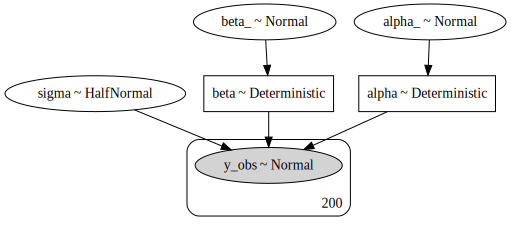

In [40]:
import pymc3 as pm
import theano

x_shared = theano.shared(x)

with pm.Model() as lineFittingModel:
    
    alpha_ = pm.Normal('alpha_', mu=0, sigma=10)
    beta_ = pm.Normal('beta_', mu=0, sigma=10)
    sigma = pm.HalfNormal('sigma', sigma=1)
    
    alpha = pm.Deterministic("alpha", alpha_)
    beta = pm.Deterministic("beta", beta_)
    mu_calc = alpha * x_shared + beta
#     mu = pm.Deterministic("mu", mu_calc)
#     mu = 
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('y_obs', mu = mu_calc , sigma=sigma, observed=y_obs)
pm.model_to_graphviz(lineFittingModel)

## MAP Estimate

In [18]:
map_estimate = pm.find_MAP(model=lineFittingModel)

map_estimate

logp = 176.82, ||grad|| = 260.98: 100%|██████████| 36/36 [00:00<00:00, 3423.69it/s]           


{'alpha_': array(0.49921874),
 'beta_': array(-1.98947632),
 'sigma_log__': array(-2.33684108),
 'sigma': array(0.09663241),
 'alpha': array(0.49921874),
 'beta': array(-1.98947632),
 'mu': array([-0.11970186,  2.75666767,  1.66477462,  0.99913902, -1.21060203,
        -1.21072244, -1.69951205,  2.33463733,  1.01140247,  1.54535468,
        -1.88671467,  2.85249543,  2.16623335, -0.92943969, -1.08177201,
        -1.07388664, -0.47064203,  0.63020613,  0.16687416, -0.53560588,
         1.06500799, -1.29309683, -0.53103549, -0.16052934,  0.28731051,
         1.93026922, -0.99266738,  0.57767836,  0.96796823, -1.75758716,
         1.04350144, -1.13818794, -1.66472658,  2.74753811,  2.83113975,
         2.04619474, -0.4687873 , -1.50187883,  1.42634318,  0.20784741,
        -1.38023858,  0.48253961, -1.81780238,  2.55002154, -0.69759816,
         1.31795908, -0.43335621,  0.6068007 ,  0.73980385, -1.06664824,
         2.85087185,  1.880132  ,  2.70067846,  2.47766951,  0.99535242,
        

## NUTS Sampler

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a32b40f28>,
      dtype=object)

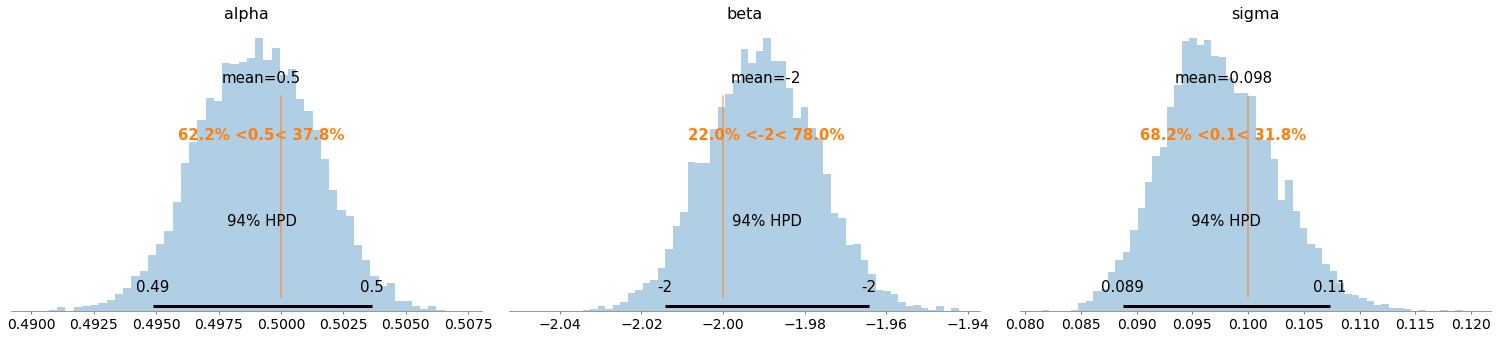

In [20]:
pm.plot_posterior(trace, var_names=['alpha', 'beta', 'sigma'], ref_val=list(true_params), kind="%hist")

In [19]:
with lineFittingModel:
    trace = pm.sample(draws=2000, tune = 2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_, alpha_]
Sampling 4 chains, 0 divergences: 100%|██████████| 16000/16000 [00:04<00:00, 3534.64draws/s]


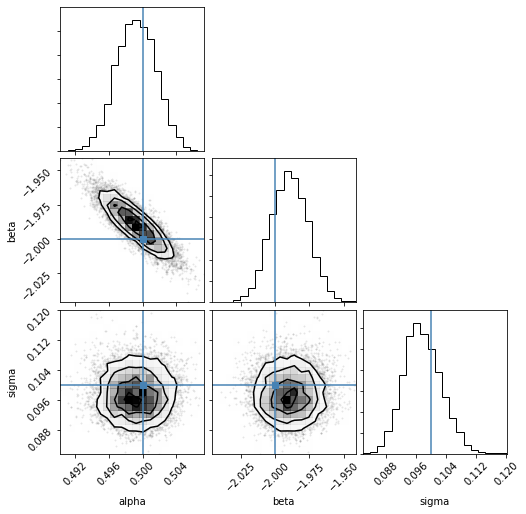

In [22]:
import corner
samples = np.vstack([trace[k] for k in ["alpha", "beta", "sigma"]]).T
corner.corner(samples, truths=true_params, labels=["alpha", "beta", "sigma"]);

/Users/hahuja/opt/anaconda3/envs/bayes3/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/hahuja/opt/anaconda3/envs/bayes3/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/hahuja/opt/anaconda3/envs/bayes3/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/hahuja/opt/anaconda3/envs/bayes3/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument b

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a2cfa49b0>,
      dtype=object)

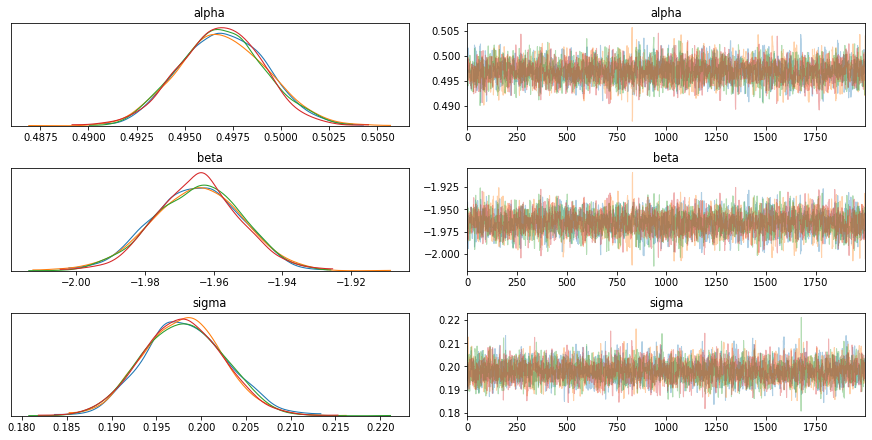

In [10]:
pm.plot_trace(trace, var_names=['alpha', 'beta', 'sigma'])

## MCMC

In [41]:
import theano

f = theano.function(lineFittingModel.vars, [lineFittingModel.logpt] + lineFittingModel.deterministics)
    
def log_prob_func(params):
    dct = lineFittingModel.bijection.rmap(params)
    args = (dct[k.name] for k in lineFittingModel.vars)
    results = f(*args)
    return tuple(results)

In [42]:
[lineFittingModel.logpt] + lineFittingModel.deterministics

[__logp, sigma, alpha, beta]

In [43]:
import emcee

with lineFittingModel:
    # First we work out the shapes of all of the deterministic variables
    res = pm.find_MAP()
    vec = lineFittingModel.bijection.map(res)
    initial_blobs = log_prob_func(vec)[1:]
    dtype = [(var.name, float, np.shape(b)) for var, b in zip(lineFittingModel.deterministics, initial_blobs)]
    
    # Then sample as usual
    coords = vec + 1e-5 * np.random.randn(25, len(vec))
    nwalkers, ndim = coords.shape
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob_func, blobs_dtype=dtype)
    sampler.run_mcmc(coords, 20000, progress=True)

logp = 176.82, ||grad|| = 260.98: 100%|██████████| 36/36 [00:00<00:00, 3199.72it/s]           
100%|██████████| 20000/20000 [00:27<00:00, 725.73it/s]


In [44]:
sampler.get_blobs(flat=True, discard=100, thin=30)

array([(0.0946221 , 0.4995179 , -2.00385493),
       (0.09976284, 0.50349488, -2.01408899),
       (0.09573983, 0.49961761, -1.98560177), ...,
       (0.10625659, 0.50120715, -1.99866405),
       (0.09366513, 0.49802644, -1.98003425),
       (0.09738813, 0.49912536, -1.99875184)],
      dtype=[('sigma', '<f8'), ('alpha', '<f8'), ('beta', '<f8')])

In [45]:
df = pd.DataFrame.from_records(sampler.get_blobs(flat=True, discard=100, thin=30))

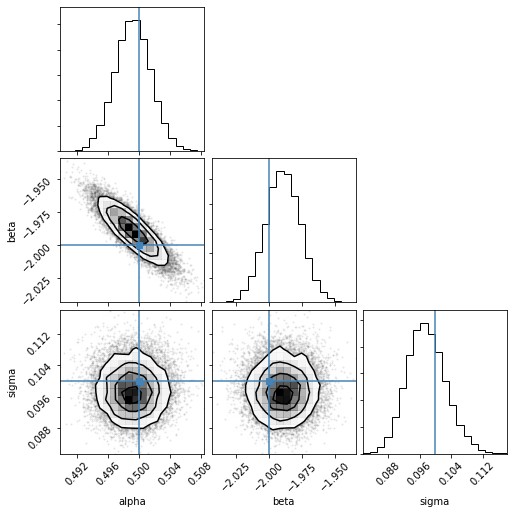

In [46]:
import pandas as pd
df = pd.DataFrame.from_records(sampler.get_blobs(flat=True, discard=100, thin=30))
corner.corner(df[["alpha", "beta", "sigma"]], truths=true_params);

In [ ]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["alpha", "beta", "logs"]

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha = .3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

In [ ]:
tau = sampler.get_autocorr_time()
print(tau)